## Proyecto EDA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datasets
df_meta = pd.read_csv('./src/data/metacritic-games-data.csv')
df_sales = pd.read_csv('./src/data/vgsales.csv') # El nombre depende del que bajes

# Previsualización
df_meta.head()

,name,platform,r-date,score,user score,developer,genre,players,critics,users
0,The Legend of Zelda: Ocarina of Time,Nintendo64,"November 23, 1998",99,9.1,Nintendo,"Action Adventure,Fantasy",1 Player,22,5749
1,Tony Hawk's Pro Skater 2,PlayStation,"September 20, 2000",98,7.4,NeversoftEntertainment,"Sports,Alternative,Skateboarding",1-2,19,647
2,Grand Theft Auto IV,PlayStation3,"April 29, 2008",98,7.6,RockstarNorth,"Action Adventure,Modern,Modern,Open-World",1 Player,64,3806
3,SoulCalibur,Dreamcast,"September 8, 1999",98,8.5,Namco,"Action,Fighting,3D",1-2,24,324
4,Grand Theft Auto IV,Xbox360,"April 29, 2008",98,7.9,RockstarNorth,"Action Adventure,Modern,Modern,Open-World",1 Player,86,3364


In [5]:
# 1. Limpiar espacios en blanco en los nombres
df_meta['name'] = df_meta['name'].str.strip()
df_sales['Name'] = df_sales['Name'].str.strip()

# 2. Unir los DataFrames por nombre y plataforma
# Nota: A veces las plataformas se llaman distinto (ej: "PS4" vs "PlayStation 4"), 
# asegúrate de mapearlas si es necesario.
df_combined = pd.merge(df_meta, df_sales, left_on=['name', 'platform'], right_on=['Name', 'Platform'], how='inner')

# 3. Limpiar puntuaciones de usuario (Metacritic a veces tiene "tbd")
df_combined = df_combined[df_combined['user score'] != 'tbd']
df_combined['user score'] = df_combined['user score'].astype(float)

# 4. Escalar el User Score (0-10) a la misma escala que el Critic Score (0-100)
df_combined['user_score_100'] = df_combined['user score'] * 10

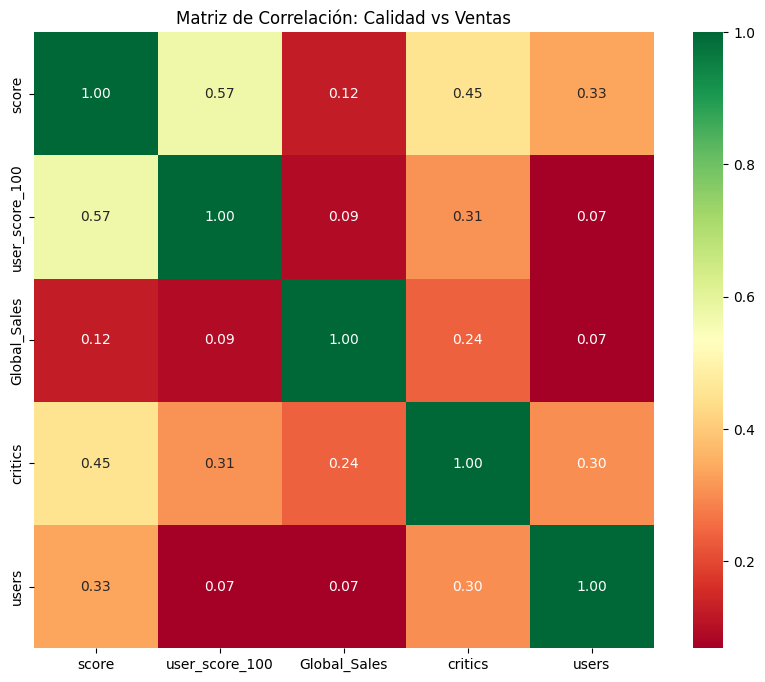

In [6]:
# Seleccionar columnas numéricas para correlación
cols_corr = ['score', 'user_score_100', 'Global_Sales', 'critics', 'users']
correlation_matrix = df_combined[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Matriz de Correlación: Calidad vs Ventas')
plt.show()

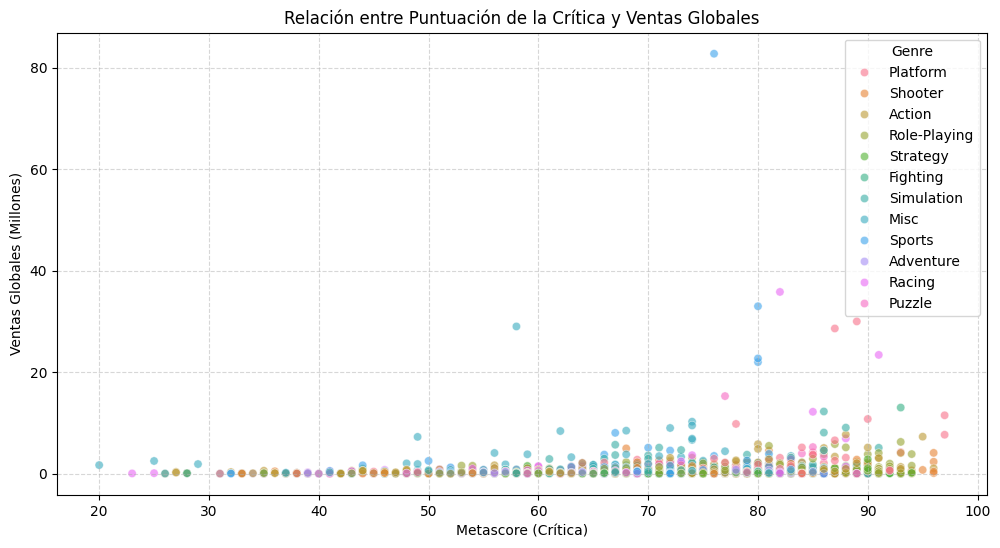

In [7]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_combined, x='score', y='Global_Sales', alpha=0.6, hue='Genre')
plt.title('Relación entre Puntuación de la Crítica y Ventas Globales')
plt.xlabel('Metascore (Crítica)')
plt.ylabel('Ventas Globales (Millones)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [8]:
# Calcular la diferencia (Prensa - Usuarios)
df_combined['opinion_gap'] = df_combined['score'] - df_combined['user_score_100']

# Top 10 juegos más "odiados" por el público pero amados por la prensa
polemicos = df_combined.sort_values(by='opinion_gap', ascending=False).head(10)
print(polemicos[['name', 'score', 'user_score_100', 'opinion_gap']])

                                name  score  user_score_100  opinion_gap
497              Company of Heroes 2     80            21.0         59.0
1105      Thrillville: Off the Rails     72            15.0         57.0
361            Football Manager Live     82            30.0         52.0
50         Tiger Woods PGA Tour 2005     91            39.0         52.0
1186  Call of Duty: Modern Warfare 3     70            20.0         50.0
654   Call of Duty: Modern Warfare 3     78            29.0         49.0
128                       Diablo III     88            41.0         47.0
1321            Call of Duty: Ghosts     68            22.0         46.0
508                   World of Tanks     80            35.0         45.0
1052                     Thrillville     72            28.0         44.0


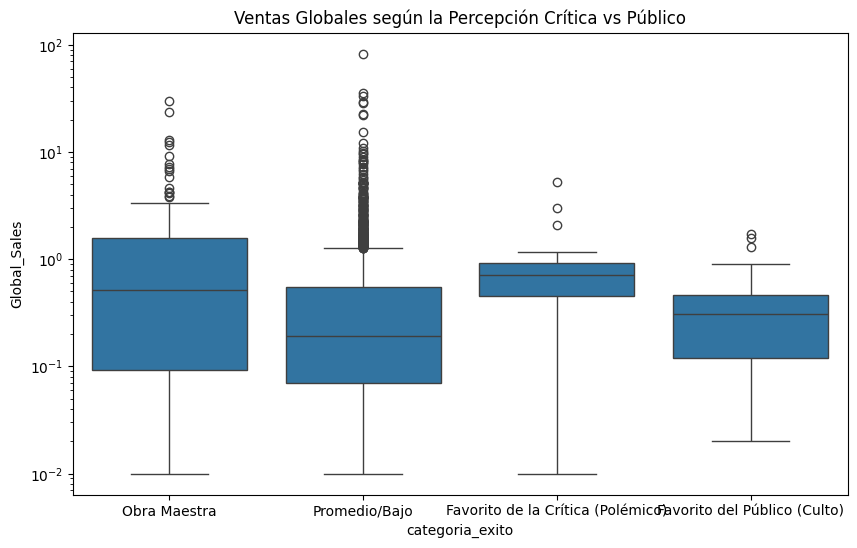

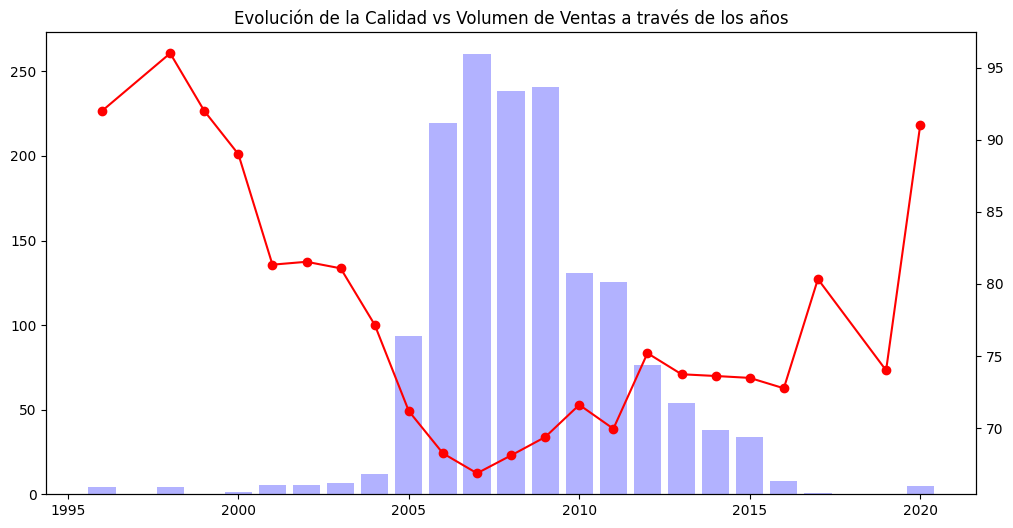

In [9]:
# --- CLASIFICACIÓN POR CUADRANTES ---
def clasificar_juego(row):
    if row['score'] >= 85 and row['user_score_100'] >= 85:
        return 'Obra Maestra'
    elif row['score'] >= 85 and row['user_score_100'] < 70:
        return 'Favorito de la Crítica (Polémico)'
    elif row['score'] < 70 and row['user_score_100'] >= 85:
        return 'Favorito del Público (Culto)'
    else:
        return 'Promedio/Bajo'

df_combined['categoria_exito'] = df_combined.apply(clasificar_juego, axis=1)

# Visualización de los Cuadrantes
plt.figure(figsize=(10,6))
sns.boxplot(x='categoria_exito', y='Global_Sales', data=df_combined)
plt.title('Ventas Globales según la Percepción Crítica vs Público')
plt.yscale('log') # Usamos escala logarítmica si hay mucha diferencia en ventas
plt.show()

# --- ANÁLISIS DE VENTAS POR DÉCADA ---
df_combined['year'] = pd.to_datetime(df_combined['r-date']).dt.year
ventas_tiempo = df_combined.groupby('year')['Global_Sales'].sum()
score_tiempo = df_combined.groupby('year')['score'].mean()

fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
ax1.bar(ventas_tiempo.index, ventas_tiempo, alpha=0.3, color='blue', label='Ventas')
ax2.plot(score_tiempo.index, score_tiempo, color='red', marker='o', label='Calidad Media')
plt.title('Evolución de la Calidad vs Volumen de Ventas a través de los años')
plt.show()

¡Archivos cargados con éxito desde ../data/!


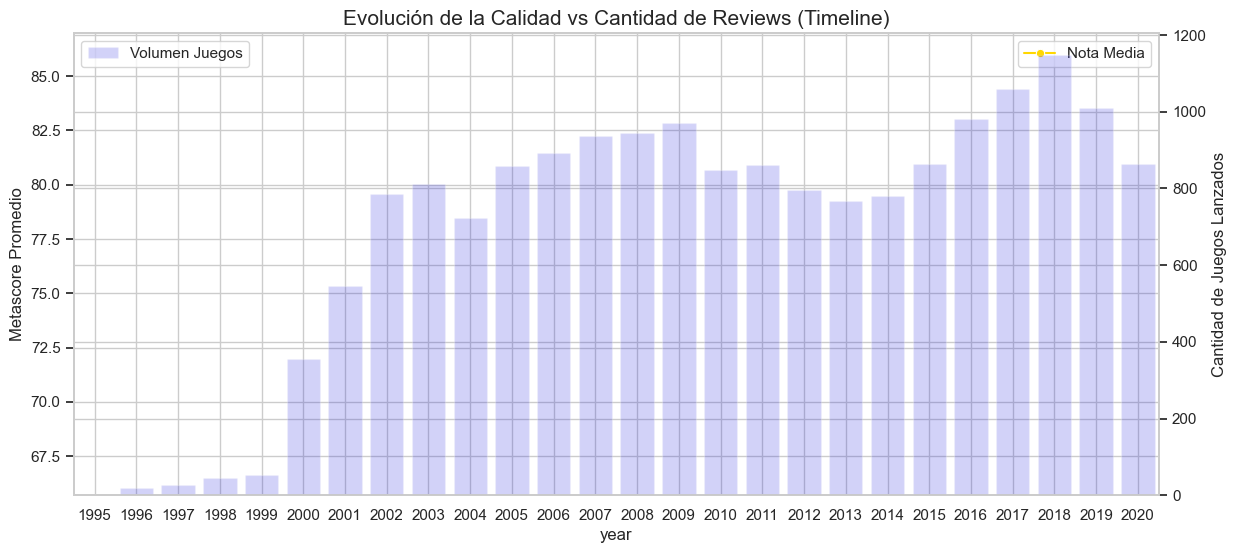

C:\Users\danma\AppData\Local\Temp\ipykernel_16316\53867724.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_polemicos, x='polemic_diff', y='name', palette='RdBu_r')


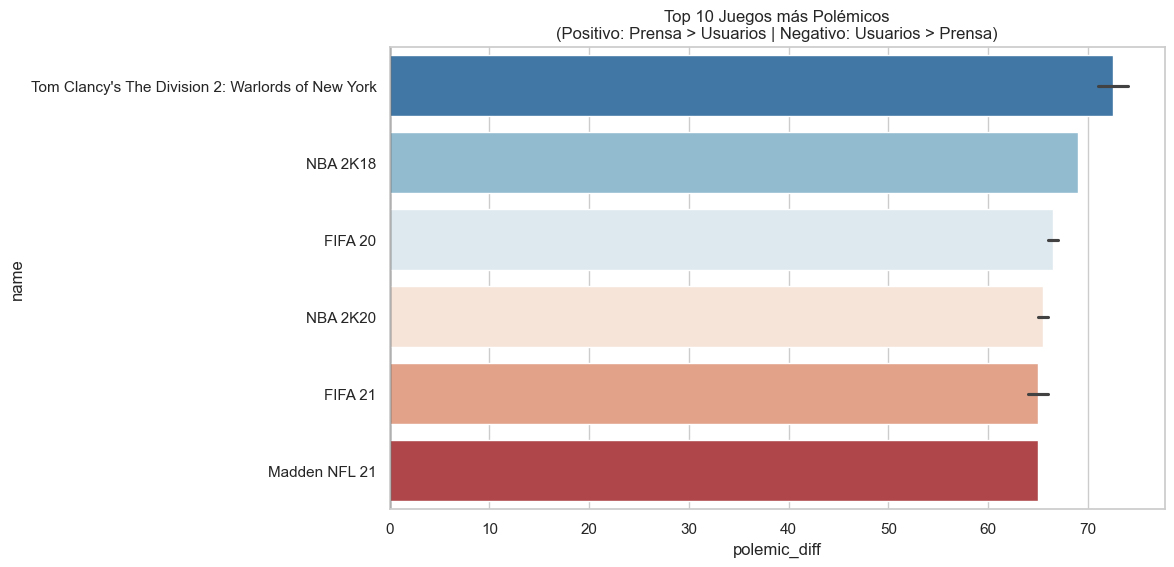

C:\Users\danma\AppData\Local\Temp\ipykernel_16316\53867724.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_boxes, x='platform', y='score', palette='Spectral')


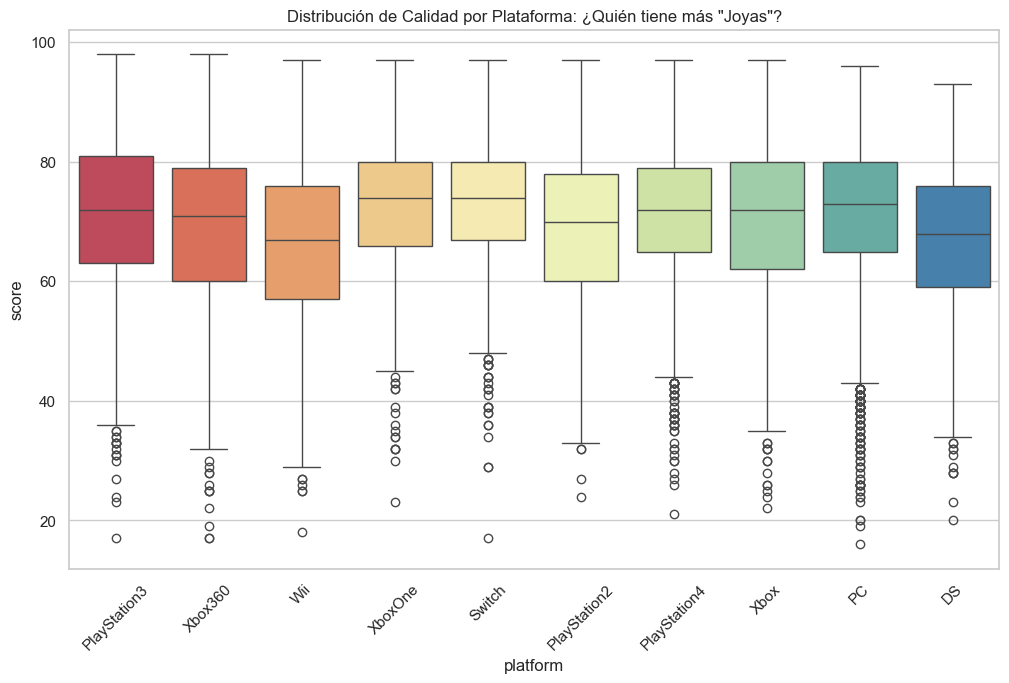

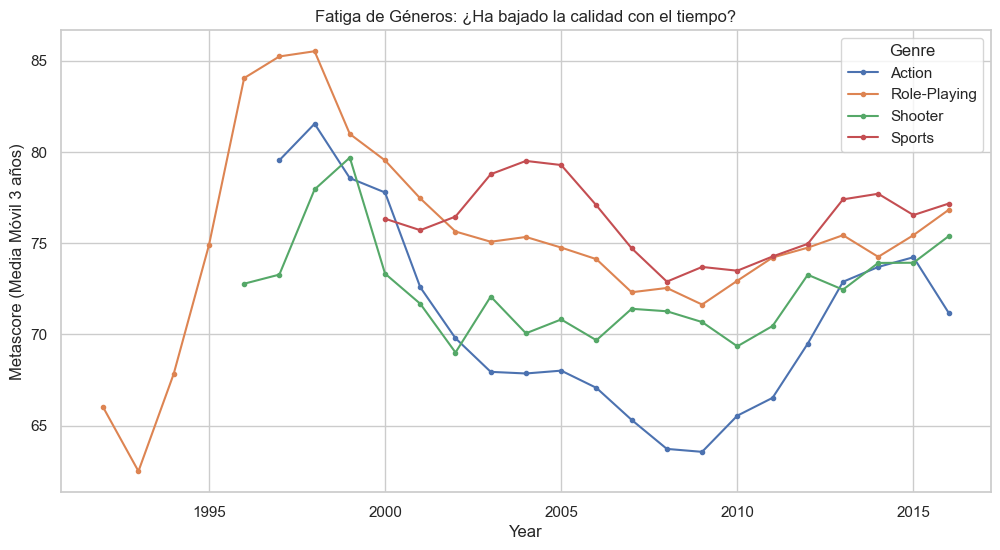

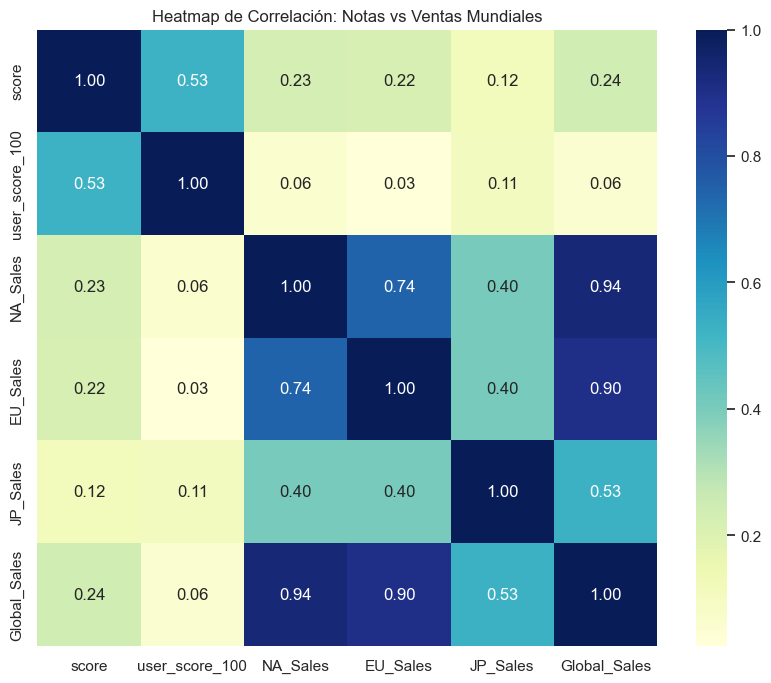

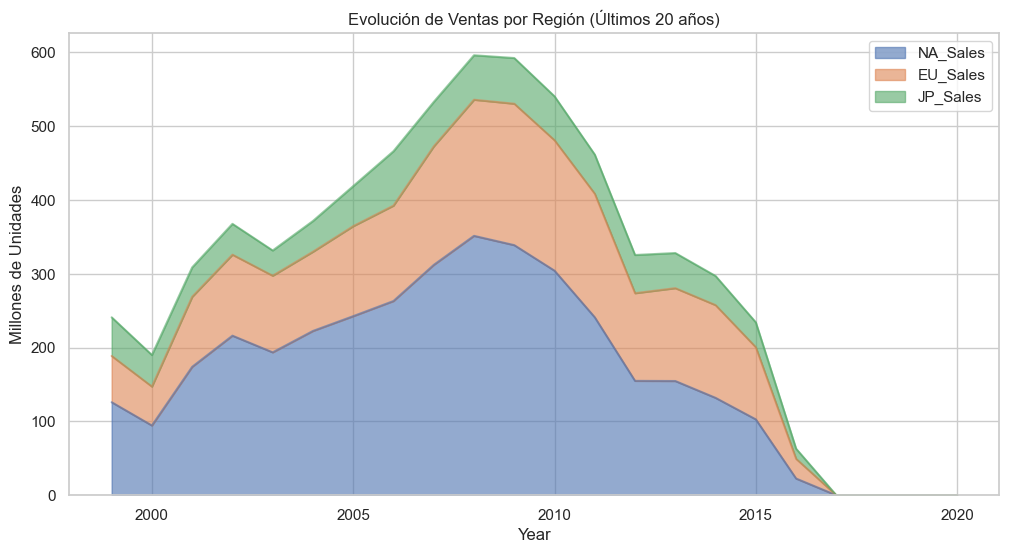

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración visual para que los gráficos se vean profesionales
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 1. CARGA DE DATOS CON RUTAS RELATIVAS CORRECTAS ---
try:
    df_meta = pd.read_csv('../data/metacritic-games-data.csv')
    df_sales = pd.read_csv('../data/vgsales.csv')
    print("¡Archivos cargados con éxito desde ../data/!")
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo. Verifica la ruta. {e}")

# --- 2. PREPARACIÓN Y LIMPIEZA ---
# Fechas y Años
df_meta['r-date'] = pd.to_datetime(df_meta['r-date'])
df_meta['year'] = df_meta['r-date'].dt.year

# Normalización de User Score (Metacritic usa escala 0-10 para usuarios y 0-100 para crítica)
df_meta['user score'] = pd.to_numeric(df_meta['user score'], errors='coerce')
df_meta['user_score_100'] = df_meta['user score'] * 10

# Unir datasets para análisis de ventas vs calidad
# Usamos 'inner' para analizar juegos que tengan tanto nota como datos de venta
df_combined = pd.merge(df_meta, df_sales, left_on='name', right_on='Name', how='inner')

# --- 3. EVOLUCIÓN TEMPORAL Y LA EDAD DE ORO ---
df_gold = df_meta.groupby('year')['score'].agg(['mean', 'count']).dropna()

fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

sns.lineplot(data=df_gold, x=df_gold.index, y='mean', ax=ax1, color='gold', marker='o', label='Nota Media')
sns.barplot(data=df_gold, x=df_gold.index, y='count', ax=ax2, alpha=0.2, color='blue', label='Volumen Juegos')

ax1.set_title('Evolución de la Calidad vs Cantidad de Reviews (Timeline)', fontsize=15)
ax1.set_ylabel('Metascore Promedio')
ax2.set_ylabel('Cantidad de Juegos Lanzados')
plt.xticks(rotation=45)
plt.show()

# --- 4. LOS MÁS POLÉMICOS (BRECHA CRÍTICA VS PÚBLICO) ---
df_meta['polemic_diff'] = df_meta['score'] - df_meta['user_score_100']
# Mayor diferencia absoluta
top_polemicos = df_meta.dropna(subset=['polemic_diff']).copy()
top_polemicos['abs_diff'] = top_polemicos['polemic_diff'].abs()
top_10_polemicos = top_polemicos.sort_values('abs_diff', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_polemicos, x='polemic_diff', y='name', palette='RdBu_r')
plt.title('Top 10 Juegos más Polémicos\n(Positivo: Prensa > Usuarios | Negativo: Usuarios > Prensa)')
plt.axvline(0, color='black', lw=1)
plt.show()

# --- 5. BOXPLOTS POR PLATAFORMA (JOYAS VS BASURA) ---
# Filtramos las plataformas con más juegos para limpiar el gráfico
top_platforms = df_meta['platform'].value_counts().nlargest(10).index
df_boxes = df_meta[df_meta['platform'].isin(top_platforms)]

plt.figure(figsize=(12, 7))
sns.boxplot(data=df_boxes, x='platform', y='score', palette='Spectral')
plt.title('Distribución de Calidad por Plataforma: ¿Quién tiene más "Joyas"?')
plt.xticks(rotation=45)
plt.show()

# --- 6. FATIGA DE GÉNEROS ---
# Analizamos la evolución de FPS (Shooter) y Sports
genres_interest = ['Shooter', 'Sports', 'Action', 'Role-Playing']
df_fatigue = df_combined[df_combined['Genre'].isin(genres_interest)]
df_fatigue_pivot = df_fatigue.groupby(['Year', 'Genre'])['score'].mean().unstack()

df_fatigue_pivot.rolling(window=3).mean().plot(figsize=(12, 6), marker='.')
plt.title('Fatiga de Géneros: ¿Ha bajado la calidad con el tiempo?')
plt.ylabel('Metascore (Media Móvil 3 años)')
plt.show()

# --- 7. HEATMAP DE CORRELACIÓN ---
plt.figure(figsize=(10, 8))
cols = ['score', 'user_score_100', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales']
sns.heatmap(df_combined[cols].corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Heatmap de Correlación: Notas vs Ventas Mundiales')
plt.show()

# --- 8. TENDENCIAS POR PAÍSES ---
ventas_regionales = df_sales.groupby('Year')[['NA_Sales', 'EU_Sales', 'JP_Sales']].sum().tail(20)
ventas_regionales.plot(kind='area', stacked=True, alpha=0.6, figsize=(12, 6))
plt.title('Evolución de Ventas por Región (Últimos 20 años)')
plt.ylabel('Millones de Unidades')
plt.show()